# **Download Data**

In [13]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 63.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 43.6MB/s]


# **Import Some Package**

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import csv
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069
###############?????????????????#############
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(myseed)

In [27]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_cruve(loss_record, title=''):
  total_steps = len(loss_record['train'])
  x_1 = range(total_steps)
  x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
  figure(figsize=(6, 4))
  plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
  plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
  plt.ylim(0.0, 5.)
  plt.xlabel('Training steps')
  plt.ylabel('MSE loss')
  plt.title('Learning curve of {}'.format(title))
  plt.legend()
  plt.show()

def plot_pred(dv_set, model, device, lim=35, preds=None, targets=None):
  if preds is None or target is None:
    model.eval()
    preds, targets = [], []
    for x, y in dv_set:
      x, y = x.to(device), y.to(device)
      with torch.no_grad():
        pred = model(x)
        preds.append(pred.detach().cpu())
        targets.append(y.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()

  figure(figsize=(5, 5))
  plt.scatter(targets, preds, c='r', alpha=0.5)
  plt.plot([-0.2, lim], [-0.2, lim], c='b')
  plt.xlim(-0.2, lim)
  plt.ylim(-0.2, lim)
  plt.xlabel('ground truth value')
  plt.ylabel('predicted value')
  plt.title('Ground Truth v.s. Prediction')
  plt.show()

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [5]:
class COVID19Dataset(Dataset):
  def __init__(self,
               path,
               mode='train',
               target_only=False):
    self.mode = mode

    # read data into numpy array
    with open(path, 'r') as fp:
      data = list(csv.reader(fp))
      data = np.array(data[1:])[:, 1:].astype(float)
    
    if not target_only:
      feats = list(range(93))
    else:
      pass
    
    if mode == 'test':
      data = data[:, feats]
      self.data = torch.FloatTensor(data)
    else:
      target = data[:, -1]
      data = data[:, feats]

      if mode == 'train':
        indices = [i for i in range(len(data)) if i % 10 != 0]
      elif mode == 'dev':
        indices = [i for i in range(len(data)) if i % 10 == 0]
      
      self.data = torch.FloatTensor(data[indices])
      self.target = torch.FloatTensor(target[indices])
    
    self.data[:, 40:] = \
        (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True))\
         / self.data[:, 40:].std(dim=0, keepdim=True)
    
    self.dim = self.data.shape[1]

    print('finish reading the {} set of COVID19 Dataset ({} samples found, each dim = {}'
    .format(mode, len(self.data), self.dim))

  def __getitem__(self, index):
    if self.mode in ['train', 'dev']:
      return self.data[index], self.target[index]
    else:
      return self.data[index]
  
  def __len__(self):
    return len(self.data)

## **DataLoader**

In [6]:
def pre_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
  dataset = COVID19Dataset(path, mode=mode, target_only=target_only)
  dataloader = DataLoader(
      dataset,
      batch_size,
      shuffle=(mode == 'train'), drop_last=False,
      num_workers=n_jobs,
      pin_memory=True
  )
  return dataloader

# **Deep Neural Network**
`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.

In [7]:
class NeuralNet(nn.Module):
  def __init__(self, input_dim):
    super(NeuralNet, self).__init__()

    self.net = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
    )
    # 均方误差
    self.criterion = nn.MSELoss(reduction='mean')
  
  def forward(self, x):
    return self.net(x).squeeze(1)
  
  def cal_loss(self, pred, target):
    return self.criterion(pred, target)

In [28]:
?nn.Sequential

# **Train/Dev/Test**

## **Training**

In [8]:
def train(tr_set, dv_set, model, config, device):
  n_epoch = config['n_epochs']

  optimizer = getattr(torch.optim, config['optimizer'])(
      model.parameters(), **config['optim_hparas']
  )

  min_mse = 1000.
  loss_record = {'train': [], 'dev': []}
  early_stop_cnt = 0
  epoch = 0
  while epoch < n_epoch:
    model.train()
    for x, y in tr_set:
      optimizer.zero_grad()
      x, y = x.to(device), y.to(device)
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
      mse_loss.backward() # 计算梯度
      optimizer.step() # 更新模型
      loss_record['train'].append(mse_loss.detach().cpu().item())
    
    dev_mse = dev(dv_set, model, device)
    if dev_mse < min_mse:
      min_mse = dev_mse
      print('Saving model (epoch={:4d}, loss={:.4f})'.format(epoch + 1, min_mse))
      torch.save(model.state_dict(), config['save_path'])
      early_stop_cnt = 0
    else:
      early_stop_cnt += 1
    
    epoch += 1
    loss_record['dev'].append(dev_mse)
    if early_stop_cnt > config['early_stop']:
      break

  print('Finish training after {} apoch'.format(epoch))
  return min_mse, loss_record

## **Validation**

In [9]:
def dev(dv_set, model, device):
  model.eval()
  total_loss = 0
  for x, y in dv_set:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
    total_loss += mse_loss.detach().cpu().item() * len(x)
  total_loss = total_loss / len(dv_set.dataset)

  return total_loss

## **Testing**

In [31]:
def test(tt_set, model, device):
  model.eval()
  preds = []
  for x in tt_set:
    x = x.to(device)
    with torch.no_grad():
      pred = model(x)
      preds.append(pred.detach().cpu())
  preds = torch.cat(preds, dim=0).numpy()
  return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [11]:
device = get_device()
os.makedirs('models', exist_ok=True)
target_only = False

config = {
    'n_epochs': 3000,
    'batch_size': 270,
    'optimizer': 'SGD',
    'optim_hparas': {
        'lr': 0.001,
        'momentum': 0.9
    },
    'early_stop': 200,
    'save_path': 'models/model.pth'
}

# **Load Data and Model**

In [14]:
tr_set = pre_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = pre_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = pre_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

finish reading the train set of COVID19 Dataset (2430 samples found, each dim = 93
finish reading the dev set of COVID19 Dataset (270 samples found, each dim = 93
finish reading the test set of COVID19 Dataset (893 samples found, each dim = 93


In [23]:
model = NeuralNet(tr_set.dataset.dim).to(device)

# **Start Training!**

In [24]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch=   1, loss=99.8190)
Saving model (epoch=   2, loss=32.0219)
Saving model (epoch=   3, loss=24.6171)
Saving model (epoch=   4, loss=20.2555)
Saving model (epoch=   5, loss=11.2592)
Saving model (epoch=   6, loss=7.2164)
Saving model (epoch=   7, loss=5.5015)
Saving model (epoch=   8, loss=4.8247)
Saving model (epoch=   9, loss=4.1287)
Saving model (epoch=  10, loss=3.6483)
Saving model (epoch=  11, loss=3.3119)
Saving model (epoch=  12, loss=3.0631)
Saving model (epoch=  13, loss=2.8601)
Saving model (epoch=  14, loss=2.7015)
Saving model (epoch=  15, loss=2.4921)
Saving model (epoch=  16, loss=2.3523)
Saving model (epoch=  17, loss=2.2348)
Saving model (epoch=  18, loss=2.1235)
Saving model (epoch=  19, loss=2.0259)
Saving model (epoch=  20, loss=1.9114)
Saving model (epoch=  21, loss=1.8478)
Saving model (epoch=  22, loss=1.7437)
Saving model (epoch=  23, loss=1.6927)
Saving model (epoch=  24, loss=1.5945)
Saving model (epoch=  25, loss=1.5633)
Saving model (epoch=

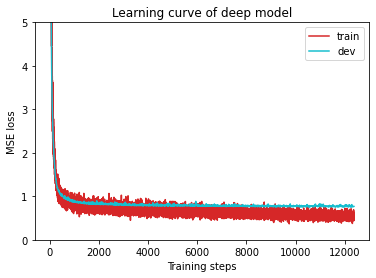

In [25]:
plot_learning_cruve(model_loss_record, title='deep model')

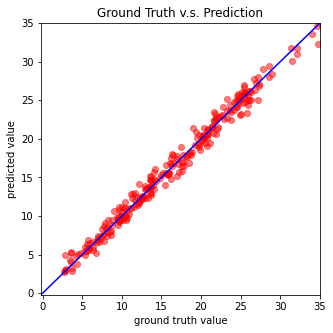

In [28]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)

# **Testing**

In [32]:
def save_pred(preds, file):
  print('Saving results to {}'.format(file))
  with open(file, 'w') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'tested_positive'])
    for i, p in enumerate(preds):
      writer.writerow([i, p])

preds = test(tt_set, model, device)
save_pred(preds, 'pred.csv')

Saving results to pred.csv
